#  Target Variable Creation

Bu notebook'ta popülarite skorunu ve target değişkenini oluşturacağız.

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Veriyi yükle
df = pd.read_parquet("eda_data.parquet")

print(f" Veri yüklendi: {df.shape[0]:,} oyun, {df.shape[1]} özellik")

 Veri yüklendi: 63,389 oyun, 47 özellik


## 1. Veri Kontrolü

Yorumsuz oyunları kontrol edelim.

In [22]:
# Yorum kontrolü
both_zero = ((df['Positive'] == 0) & (df['Negative'] == 0)).sum()
has_reviews = ((df['Positive'] > 0) | (df['Negative'] > 0)).sum()

if both_zero > 0:
    df = df[(df['Positive'] > 0) | (df['Negative'] > 0)].copy()
    print(f"Temizlendi! Kalan oyun sayısı: {len(df):,}")
else:
    print(f"Tüm oyunların en az 1 yorumu var ({has_reviews:,} oyun)")

Tüm oyunların en az 1 yorumu var (63,389 oyun)


## 2. Feature Engineering

Popülarite skorunu hesaplamak için gerekli özellikleri hazırlayalım.

**4 özellik hazırlanacak:**
- Sahip sayısı (normalize)
- Oynanma süresi (normalize)
- Yorum sayısı (log + normalize)
- Yorum kalitesi (pozitif oran)

In [23]:
# Review count
df['review_count'] = df['Positive'] + df['Negative']

# Normalizasyon
scaler = MinMaxScaler()
df['norm_owners'] = scaler.fit_transform(df[['Estimated owners numeric']])
df['norm_playtime'] = scaler.fit_transform(df[['Average playtime forever']])

# Log transformation sonrası normalize
df['log_reviews'] = np.log1p(df['review_count'])
df['norm_reviews'] = scaler.fit_transform(df[['log_reviews']])

# Review quality (pozitif oran)
df['review_quality'] = df['Positive'] / df['review_count']


## 3. Popülarite Skoru

Ağırlıklı skoru hesaplayalım:
-  30% Sahip sayısı
-  30% Yorum sayısı  
-  25% Oynanma süresi
-  15% Yorum kalitesi

In [24]:
df['popularity_score'] = (
    0.30 * df['norm_owners'] +
    0.30 * df['norm_reviews'] +
    0.25 * df['norm_playtime'] +
    0.15 * df['review_quality']
)

print(f" Popülarite skoru hesaplandı")
print(f"\n İstatistikler:")
print(f"   Min:      {df['popularity_score'].min():.4f}")
print(f"   Maks:     {df['popularity_score'].max():.4f}")
print(f"   Ortalama: {df['popularity_score'].mean():.4f}")
print(f"   Medyan:   {df['popularity_score'].median():.4f}")

 Popülarite skoru hesaplandı

 İstatistikler:
   Min:      0.0000
   Maks:     0.7624
   Ortalama: 0.1706
   Medyan:   0.1700


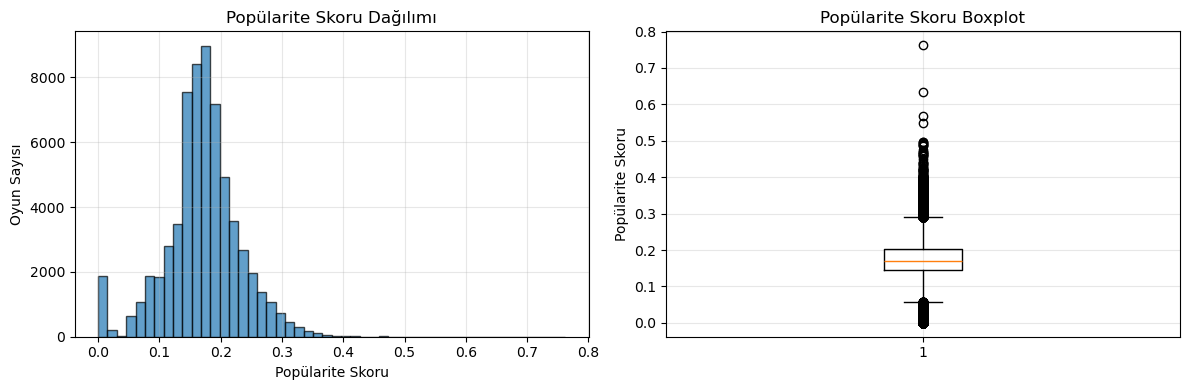

In [25]:
# Görselleştirme
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['popularity_score'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Popülarite Skoru')
plt.ylabel('Oyun Sayısı')
plt.title('Popülarite Skoru Dağılımı')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(df['popularity_score'], vert=True)
plt.ylabel('Popülarite Skoru')
plt.title('Popülarite Skoru Boxplot')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Target Kategorileri

Skoru 3 kategoriye bölelim: Low, Medium, High

In [26]:
# Quantile-based kategoriler (her biri %33)
low_threshold = df['popularity_score'].quantile(0.33)
high_threshold = df['popularity_score'].quantile(0.67)

df['target'] = pd.cut(
    df['popularity_score'],
    bins=[-np.inf, low_threshold, high_threshold, np.inf],
    labels=['Low', 'Medium', 'High']
)

# Encoding
df['target_encoded'] = df['target'].map({'Low': 0, 'Medium': 1, 'High': 2})

print(f"\n Dağılım:")
target_dist = df['target'].value_counts().sort_index()
for cat, count in target_dist.items():
    pct = count/len(df)*100
    bar = "█" * int(pct/2)
    print(f"   {cat:8} {count:6,} ({pct:5.1f}%) {bar}")


 Dağılım:
   Low      20,919 ( 33.0%) ████████████████
   Medium   21,623 ( 34.1%) █████████████████
   High     20,847 ( 32.9%) ████████████████


/var/folders/bx/flr0_6zx1f9b8ydzct1qv_6m0000gn/T/ipykernel_7696/1732028637.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 0].boxplot([df[df['target']==cat]['Estimated owners numeric'] for cat in ['Low', 'Medium', 'High']],
/var/folders/bx/flr0_6zx1f9b8ydzct1qv_6m0000gn/T/ipykernel_7696/1732028637.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot([df[df['target']==cat]['review_count'] for cat in ['Low', 'Medium', 'High']],
/var/folders/bx/flr0_6zx1f9b8ydzct1qv_6m0000gn/T/ipykernel_7696/1732028637.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot([df[df['target']=

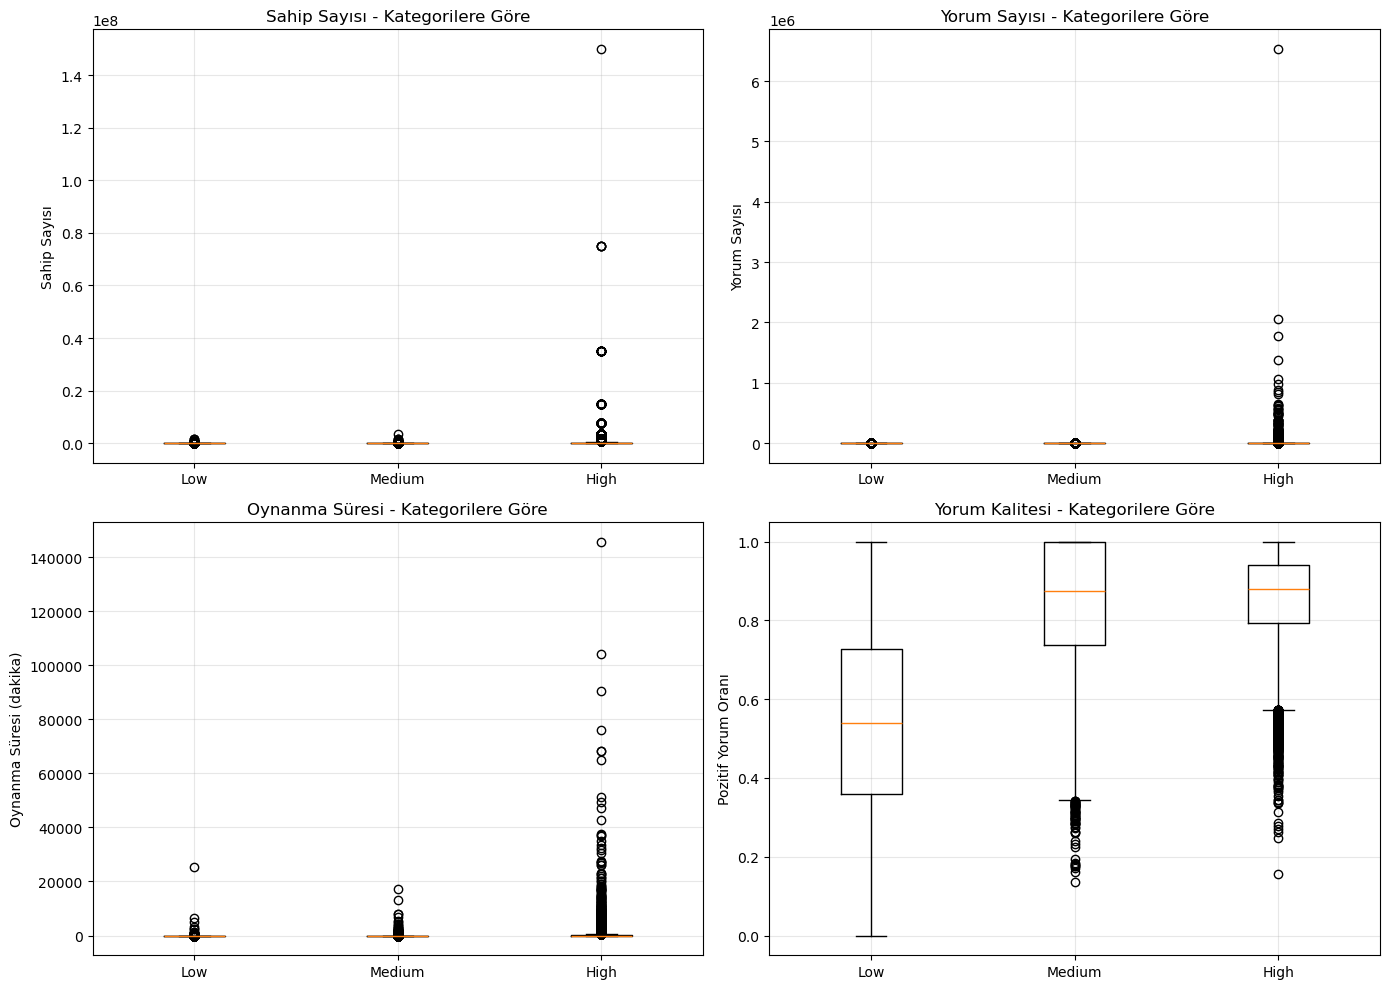

In [27]:
# Her kategorinin özelliklerini karşılaştır
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sahip sayısı
axes[0, 0].boxplot([df[df['target']==cat]['Estimated owners numeric'] for cat in ['Low', 'Medium', 'High']], 
                     labels=['Low', 'Medium', 'High'])
axes[0, 0].set_ylabel('Sahip Sayısı')
axes[0, 0].set_title('Sahip Sayısı - Kategorilere Göre')
axes[0, 0].grid(alpha=0.3)

# Yorum sayısı
axes[0, 1].boxplot([df[df['target']==cat]['review_count'] for cat in ['Low', 'Medium', 'High']], 
                     labels=['Low', 'Medium', 'High'])
axes[0, 1].set_ylabel('Yorum Sayısı')
axes[0, 1].set_title('Yorum Sayısı - Kategorilere Göre')
axes[0, 1].grid(alpha=0.3)

# Oynanma süresi
axes[1, 0].boxplot([df[df['target']==cat]['Average playtime forever'] for cat in ['Low', 'Medium', 'High']], 
                     labels=['Low', 'Medium', 'High'])
axes[1, 0].set_ylabel('Oynanma Süresi (dakika)')
axes[1, 0].set_title('Oynanma Süresi - Kategorilere Göre')
axes[1, 0].grid(alpha=0.3)

# Review quality
axes[1, 1].boxplot([df[df['target']==cat]['review_quality'] for cat in ['Low', 'Medium', 'High']], 
                     labels=['Low', 'Medium', 'High'])
axes[1, 1].set_ylabel('Pozitif Yorum Oranı')
axes[1, 1].set_title('Yorum Kalitesi - Kategorilere Göre')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Temizlik ve Kaydetme

Geçici sütunları kaldırıp veriyi kaydedelim.

In [28]:
# Geçici sütunları kaldır
temp_cols = ['log_reviews', 'norm_owners', 'norm_reviews', 'norm_playtime', 'review_quality']
df = df.drop(columns=temp_cols)

# Kaydet
df.to_parquet('data_with_target.parquet', index=False)